# Notes

1. Navmesh is a 3D space, not a 2D. It is natural that the bounding boxes of it and the whole space match.

2. X -> right; Y-> up; Z-> front (right-hand rule)

3. Sensor coordinates are relative to agent center of mass (that should have y=0)

In [1]:
import random
import magnum as mn
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R

import habitat_sim
import habitat_sim.nav as nav
from habitat.utils.visualizations import maps
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut
from habitat_sim.utils.common import quat_from_angle_axis, quat_to_angle_axis
from habitat_sim.utils.common import d3_40_colors_rgb

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


In [2]:
# Dataset and scene
dataset_config_file = "../ai2thor-hab-dataset/ai2thor-hab/ai2thor-hab.scene_dataset_config.json"
scene = "FloorPlan2_physics"

# Sensors and other sim settings
rgb_sensor = True  # @param {type:"boolean"}
depth_sensor = True  # @param {type:"boolean"}

In [3]:
# Define the simulator configuration
sim_settings = {
    "dataset": dataset_config_file,  # Scene dataset
    "scene": scene,  # Scene path
    "width": 512,  # Spatial resolution of the observations
    "height": 512,
    "default_agent": 0,
    "sensor_height": 1.5,  # Height of sensors in meters
    "color_sensor": rgb_sensor,  # RGB sensor
    "depth_sensor": depth_sensor,  # Depth sensor
    "seed": 1,
    "enable_physics": False,  # kinematics only
}

In [4]:
# Function to display the sensor data
def display_sample(rgb_obs, depth_obs, top_down_map):
    # Visualize the observations: RGB
    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")
    arr = [rgb_img]
    titles = ["rgb"]

    # Visualize the observations: Depth
    depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
    arr.append(depth_img)
    titles.append("depth")

    # Visualize the observations: Top-down map
    arr.append(top_down_map)
    titles.append("top-down map")

    # Display the images
    plt.figure(figsize=(18, 12))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)

In [5]:
# Function to create the simulator configuration
def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene_dataset_config_file = settings["dataset"]
    sim_cfg.scene_id = settings["scene"]
    sim_cfg.enable_physics = settings["enable_physics"]

    # Note: all sensors must have the same resolution
    sensors = {
        "color_sensor": {
            "sensor_type": habitat_sim.SensorType.COLOR,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
        "depth_sensor": {
            "sensor_type": habitat_sim.SensorType.DEPTH,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
    }

    sensor_specs = []
    for sensor_uuid, sensor_params in sensors.items():
        if settings[sensor_uuid]:
            sensor_spec = habitat_sim.CameraSensorSpec()
            sensor_spec.uuid = sensor_uuid
            sensor_spec.sensor_type = sensor_params["sensor_type"]
            sensor_spec.resolution = sensor_params["resolution"]
            sensor_spec.position = sensor_params["position"]
            sensor_specs.append(sensor_spec)

    # Here you can specify the amount of displacement in a forward action and the turn angle
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward": habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "turn_left": habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
        "turn_right": habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
    }

    return habitat_sim.Configuration(sim_cfg, [agent_cfg])

In [6]:
# Initialize the simulator
cfg = make_cfg(sim_settings)

In [9]:
sim = habitat_sim.Simulator(cfg)

In [10]:
# Get the root node of the active scene graph
scene_root = sim.get_active_scene_graph().get_root_node()
scene_bb = scene_root.cumulative_bb
scene_dims = scene_bb.size()

# Print bounds with one decimal case
print("Scene bounding box (X, Y, Z)")
print("Min corner: [{:.1f}, {:.1f}, {:.1f}]".format(scene_bb.min[0], scene_bb.min[1], scene_bb.min[2]))
print("Max corner: [{:.1f}, {:.1f}, {:.1f}]".format(scene_bb.max[0], scene_bb.max[1], scene_bb.max[2]))
print("Scene dimensions (X, Y, Z): [{:.1f}, {:.1f}, {:.1f}]".format(scene_dims[0], scene_dims[1], scene_dims[2]))

Scene bounding box (X, Y, Z)
Min corner: [-2.5, -0.1, -2.0]
Max corner: [3.3, 2.6, 4.0]
Scene dimensions (X, Y, Z): [5.8, 2.7, 6.0]


In [11]:
# Define navmesh settings
navmesh_settings = habitat_sim.NavMeshSettings()
navmesh_settings.agent_height = 1.5
navmesh_settings.agent_radius = 0.1
navmesh_settings.agent_max_climb = 0.2
navmesh_settings.agent_max_slope = 45.0
navmesh_settings.include_static_objects = True  # Include static objects in the navmesh computation

# Recompute the navmesh for the current scene
success = sim.recompute_navmesh(sim.pathfinder, navmesh_settings)
if not sim.pathfinder.is_loaded:
    print("Pathfinder not initialized, aborting.")
else:
    # @markdown NavMesh area and bounding box can be queried via *navigable_area* and *get_bounds* respectively.
    print("NavMesh area = {:.1f}".format(sim.pathfinder.navigable_area))
    bounds = sim.pathfinder.get_bounds()
    print("Min corner: [{:.1f}, {:.1f}, {:.1f}], \nMax corner: [{:.1f}, {:.1f}, {:.1f}]".format(
        bounds[0][0], bounds[0][1], bounds[0][2], bounds[1][0], bounds[1][1], bounds[1][2]))

NavMesh area = 48.3
Min corner: [-2.5, -0.1, -2.0], 
Max corner: [3.3, 2.6, 4.0]


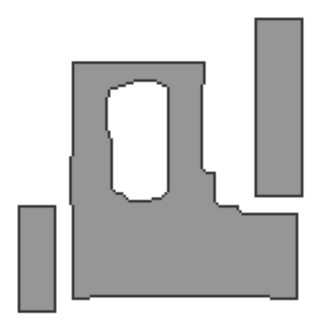

In [12]:
# Generate the top-down map at a specific height (0 by default), with given resolution
topdown_map = maps.get_topdown_map(sim.pathfinder,
    height=0,                 # height in meters to slice the map
    meters_per_pixel=0.05,      # resolution: lower = higher resolution
    draw_border=True
)

# Color the top-down map
topdown_map = maps.colorize_topdown_map(topdown_map)

# Display the top-down map
plt.figure(figsize=(4, 4))
plt.imshow(topdown_map, cmap="gray")
plt.axis('off')
plt.show()

Scene origin position: Vector(0, 0, 0)
Scene origin rotation: Quaternion({0, 0, 0}, 1) 

Bottom-left in world coordinates: [-2.5, -0.1, -2.0]
Top-right in world coordinates: [3.3, 2.6, 4.0] 

Origin in map grid coordinates: (40, 49)
Bottom-left in map grid coordinates: (-9, 9)
Top-right in map grid coordinates: (105, 128)

Origin in map grid coordinates: (49, 40)
Bottom-left in map grid coordinates: (0, 0)
Top-right in map grid coordinates: (114, 119)

Top-down map dimensions: (120, 115, 3)


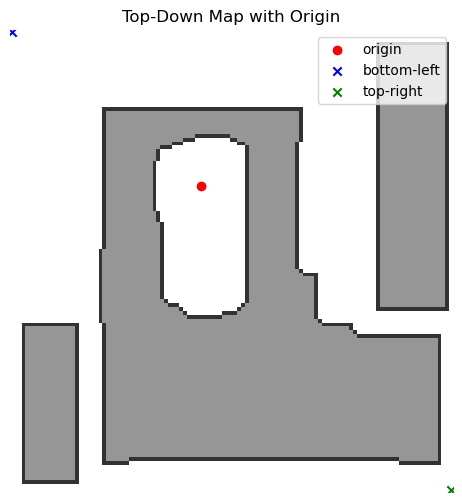

In [13]:
# Print the root node's position and rotation
scene_graph = sim.get_active_scene_graph()
root_node = scene_graph.get_root_node()
print("Scene origin position:", root_node.translation)
print("Scene origin rotation:", root_node.rotation, "\n")

# World coordinate to map grid coordinate: origin, bottom-left corner of the navigable volume and top-right corner 
origin = np.array(root_node.translation)
bottom_left = [sim.pathfinder.get_bounds()[0][0], sim.pathfinder.get_bounds()[0][1], sim.pathfinder.get_bounds()[0][2]]
top_right = [sim.pathfinder.get_bounds()[1][0], sim.pathfinder.get_bounds()[1][1], sim.pathfinder.get_bounds()[1][2]]
grid_resolution = topdown_map.shape  # (height, width)
print("Bottom-left in world coordinates: [{:.1f}, {:.1f}, {:.1f}]".format(*bottom_left))
print("Top-right in world coordinates: [{:.1f}, {:.1f}, {:.1f}]".format(*top_right), "\n")

# Convert to grid coordinates
origin_px = maps.to_grid(origin[0], origin[2], grid_resolution, pathfinder=sim.pathfinder)
bottom_left_px = maps.to_grid(bottom_left[0], bottom_left[2], grid_resolution, pathfinder=sim.pathfinder)
top_right_px = maps.to_grid(top_right[0], top_right[2], grid_resolution, pathfinder=sim.pathfinder)
print("Origin in map grid coordinates:", origin_px)
print("Bottom-left in map grid coordinates:", bottom_left_px)
print("Top-right in map grid coordinates:", top_right_px)

# Compute the offset
offset_x = min(bottom_left_px[0], top_right_px[0])
offset_z = min(bottom_left_px[1], top_right_px[1])

# Update coordinates
origin_px = (origin_px[0] - offset_x, origin_px[1] - offset_z)
bottom_left_px = (bottom_left_px[0] - offset_x, bottom_left_px[1] - offset_z)
top_right_px = (top_right_px[0] - offset_x, top_right_px[1] - offset_z)

# Print the updated coordinates
print("\nOrigin in map grid coordinates:", origin_px)
print("Bottom-left in map grid coordinates:", bottom_left_px)
print("Top-right in map grid coordinates:", top_right_px)

# Print top-down map dimensions
print("\nTop-down map dimensions:", topdown_map.shape)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(topdown_map, cmap="gray")
plt.scatter(origin_px[0], origin_px[1], c="red", marker="o", label="origin")
plt.scatter(bottom_left_px[0], bottom_left_px[1], c="blue", marker="x", label="bottom-left")
plt.scatter(top_right_px[0], top_right_px[1], c="green", marker="x", label="top-right")
plt.title("Top-Down Map with Origin")
plt.axis("off")
plt.legend()
plt.show()

In [14]:
# Initialize an agent
agent = sim.initialize_agent(sim_settings["default_agent"])
agent_state = habitat_sim.AgentState()
while(True):
    random_position = sim.pathfinder.get_random_navigable_point()
    random_position = np.array([random_position[0], 0.0, random_position[2]])
    if sim.pathfinder.is_navigable(random_position):
        break
agent_state.position = random_position
agent_state.rotation = np.quaternion(1.0, 0.0, 0.0, 0.0)
agent.set_state(agent_state)

# Print the agent's state
print("Position:", agent.state.position)
print("Rotation:", agent.state.rotation)

Position: [-0.49981213  0.          1.5339875 ]
Rotation: quaternion(1, 0, 0, 0)


In [22]:
def plot_agent_on_map(sim, agent, topdown_map, offset):

    # Get agent state
    agent_state = agent.get_state()
    agent_position = agent_state.position
    agent_rotation = agent_state.rotation  # This is a quaternion

    # Convert quaternion to yaw angle in degrees
    r = R.from_quat([agent_rotation.x, agent_rotation.y, agent_rotation.z, agent_rotation.w])
    agent_heading = r.as_euler('xyz', degrees=True)[1]  # Extract the yaw component

    # Convert agent's 3D position to 2D top-down coordinates
    map_agent_pos = maps.to_grid(
        agent_position[0], agent_position[2],  # Convert 3D position to 2D
        topdown_map.shape, 
        pathfinder=sim.pathfinder
    )

    # Print agent position and heading
    print("Agent position:", map_agent_pos)
    print("Agent heading (yaw angle in degrees):", agent_heading)

    # Compute offset
    offset_x, offset_z = offset
    map_agent_pos = (map_agent_pos[0] - offset_x, map_agent_pos[1] - offset_z)

    # Print agent position and heading
    print("\nUpdated agent position:", map_agent_pos)
    print("Agent heading (yaw angle in degrees):", agent_heading)
    
    # Plot map and agent position
    plt.figure(figsize=(6, 6))
    plt.imshow(topdown_map, cmap="gray")
    plt.scatter(map_agent_pos[1], map_agent_pos[0], c="red", marker="x", label="agent")
    plt.title("Agent Position on Top-Down Map")
    plt.axis("off")
    plt.legend()
    plt.show()

    #Colorize the top-down map
    new_map=maps.draw_agent(topdown_map, map_agent_pos, agent_heading, agent_radius_px=4)
    plt.figure(figsize=(6, 6))
    plt.imshow(new_map)
    plt.axis("off")
    plt.title("Agent Position on Top-Down Map")
    plt.show()


Agent position: (30, 79)
Agent heading (yaw angle in degrees): 0.0

Updated agent position: (39, 70)
Agent heading (yaw angle in degrees): 0.0


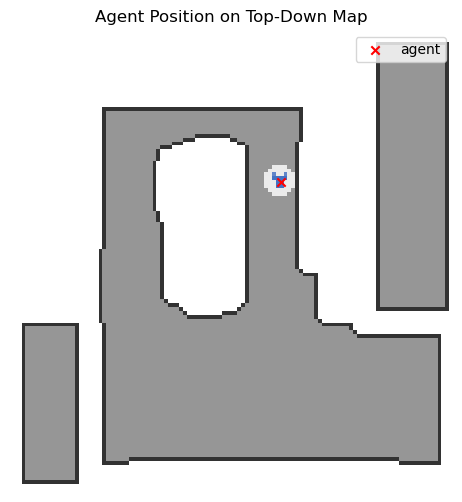

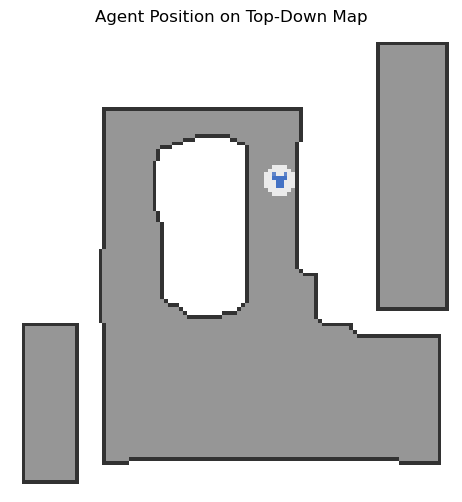

Agent position is navigable: True


In [23]:
plot_agent_on_map(sim, agent, topdown_map, (offset_x, offset_z))

# Check if agente position is navigable
agent_state = agent.get_state()
agent_position = agent_state.position
is_navigable = sim.pathfinder.is_navigable(agent_position)
print("Agent position is navigable:", is_navigable)

In [25]:
def agent_on_map_img(sim, agent, topdown_map, offset):
    # Get agent state
    agent_state = agent.get_state()
    agent_position = agent_state.position
    agent_rotation = agent_state.rotation  # This is a quaternion

    # Convert quaternion to yaw angle in degrees
    r = R.from_quat([agent_rotation.x, agent_rotation.y, agent_rotation.z, agent_rotation.w])
    agent_heading = r.as_euler('xyz', degrees=True)[1]  # Extract the yaw component

    # Convert agent's 3D position to 2D top-down coordinates
    map_agent_pos = maps.to_grid(
        agent_position[0], agent_position[2],  # Convert 3D position to 2D
        topdown_map.shape, 
        pathfinder=sim.pathfinder
    )

    # Compute offset
    offset_x, offset_z = offset
    map_agent_pos = (map_agent_pos[0] - offset_x, map_agent_pos[1] - offset_z)

    #Colorize the top-down map
    new_map=maps.draw_agent(topdown_map, map_agent_pos, agent_heading, agent_radius_px=4)

    return new_map

In [ ]:
total_frames = 0
action_names = list(cfg.agents[sim_settings["default_agent"]].action_space.keys())
max_frames = 10

while total_frames < max_frames:

    # Get agent state
    agent_state = agent.get_state()
    print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)

    # Take an action and get the observations
    action = random.choice(action_names)
    print("action", action)
    observations = sim.step(action)
    rgb = observations["color_sensor"]
    depth = observations["depth_sensor"]
    top_down_map = agent_on_map_img(sim, agent, topdown_map, (offset_x, offset_z))
    display_sample(rgb, depth, top_down_map)

    # Update frame
    total_frames += 1

: 